# Linear gression models

This notebooks shows the different linear regression models available in `tundraden`.

In [1]:
import sys
sys.path.append('..')
import tundraden as td
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

## Problem setup

The linear regression problem can be written as

\begin{equation}
    y = X\beta + \varepsilon.
\end{equation}

Let's first generate some random data to regress. Below are generated two uncorrelated regressors and a response variable with true regression coefficients $\beta=\begin{pmatrix}1\\0.5\end{pmatrix}$ and noise variance $\sigma^2=1$.

In [2]:
# regressors
n_variables = 2
mu = np.zeros(n_variables)
Sigma = np.identity(n_variables)
n_samples = 100
X = td.generate.gaussian(mu, Sigma, n_samples)

# regressand
beta = [1, 0.5]
sigma = 1
Y = td.generate.linear(X, beta, sigma)

Let's plot these in a 3d plot:

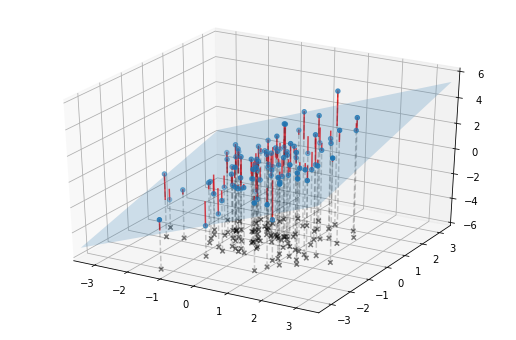

In [3]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111, projection='3d')

# scatter plot the data
ax.scatter(X[:,0], X[:,1], Y)

# plot the plane spaned by the true regression coefficients
x_min, x_max = -3.5, 3.5
y_min, y_max = -3.5, 3.5
z_min, z_max = -6, 6
XX, YY = np.meshgrid([x_min, x_max], [x_min, x_max])
ZZ = np.dot(np.array([YY, XX]).T, beta)
ax.plot_surface(XX, YY, ZZ, alpha=0.2)

# plot the residuals
for i in range(n_samples):
    ax.plot3D([X[i,0], X[i,0]], [X[i,1], X[i,1]], [Y[i], X[i,:].dot(beta)], 'r', alpha=.8)

# plot the projection onto the y=0 plane
for i in range(n_samples):
    ax.plot3D([X[i,0], X[i,0]], [X[i,1], X[i,1]], [z_min, Y[i]], 'k--', alpha=.2)
ax.scatter(X[:,0], X[:,1], z_min, marker='x', color='k', alpha=.5)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])
plt.show()

## Ordinary Least Squares (OLS)

The simplest available model is an Ordinary Least Squares (OLS) linear regression. It minimizes the following cost function,

\begin{equation}
    J(\beta) = \sum_{i=1}^{n}(y_{i} - x_{i}^{T}\beta)^{2}.
\end{equation}

It can be shown the solution is

\begin{equation}
    \hat{\beta} = (X^{T}X)^{-1}X^{T}y.
\end{equation}

In [4]:
lm = td.models.LinearRegression(fit_intercept=False)
lm.fit(X, Y)
lm.coef

array([0.96180017, 0.61202613])

The estimated coefficients are relatively close to the true coefficients. Note the intercept is not fitted since we know there is no bias.

The coefficient of determination is defined as

\begin{equation}
    R^2 = 1 - \frac{\sum_{i=1}^{n}(y_i - \hat{y}_i)^{2}}{\sum_{i=1}^{n}(y_i - \bar{y})^{2}}.
\end{equation}

In [5]:
lm.r2

0.5186169448230294

Here it is quite low since the noise variance is high compared to the variance of the true response. The fitted plane together with the true plane is plotted below.

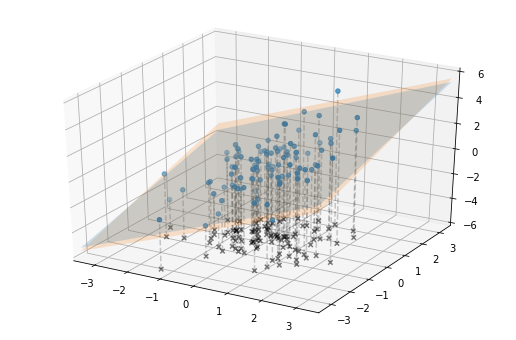

In [6]:
fig = plt.figure(figsize = (9,6))
ax = fig.add_subplot(111, projection='3d')

# scatter plot the data
ax.scatter(X[:,0], X[:,1], Y)

# plot both planes
ZZ_hat = np.dot(np.array([YY, XX]).T, lm.coef)
ax.plot_surface(XX, YY, ZZ, alpha=0.2)
ax.plot_surface(XX, YY, ZZ_hat, alpha=0.2)

# plot the projection onto the y=0 plane
for i in range(n_samples):
    ax.plot3D([X[i,0], X[i,0]], [X[i,1], X[i,1]], [z_min, Y[i]], 'k--', alpha=.2)
ax.scatter(X[:,0], X[:,1], z_min, marker='x', color='k', alpha=.5)

ax.set_xlim([x_min, x_max])
ax.set_ylim([y_min, y_max])
ax.set_zlim([z_min, z_max])
plt.show()

## Ridge regression

Ridge regression uses $L_2$ regularization. It minimizes the following cost function,

\begin{equation}
    J(\beta) = \sum_{i=1}^{n}(y_{i} - x_{i}^{T}\beta)^{2} + \lambda\sum_{i=1}^{n}\beta_i^2,
\end{equation}

where $\lambda$ is the regularization factor. It can be shown the solution is

\begin{equation}
    \hat{\beta} = (X^{T}X + \lambda I)^{-1}X^{T}y.
\end{equation}

In [7]:
lm = td.models.RidgeRegression(lambda_=10, fit_intercept=False)
lm.fit(X, Y)
lm.coef

array([0.87590999, 0.55885234])

The estimated coefficients are smaller than in the OLS case due to the regularization.

## LASSO regression

LASSO regression uses $L_1$ regularization. It minimizes the following cost function,

\begin{equation}
    J(\beta) = \sum_{i=1}^{n}(y_{i} - x_{i}^{T}\beta)^{2} + \lambda\sum_{i=1}^{n}|\beta_i|.
\end{equation}

Unlike ridge there is not a general explicit solution for LASSO regression. The solution can be approached using gradient descent.

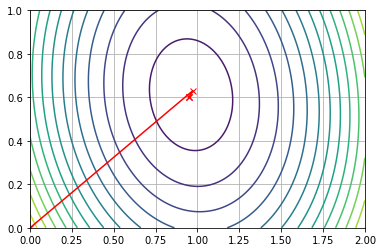

In [8]:
lm_lasso = td.models.LassoRegression(lambda_=1, fit_intercept=False, save_steps=True)
lm_lasso.fit(X, Y)

BB1, BB2 = np.meshgrid(np.linspace(0,2,200), np.linspace(0,1,200))
JJ = np.sum((Y.reshape([-1,1,1]) - np.tensordot(X, np.array([BB1, BB2]), (1,0)))**2, axis=0)
plt.figure()
plt.contour(BB1, BB2, JJ, levels=15)
plt.plot(lm_lasso.steps[:,0], lm_lasso.steps[:,1], 'rx-')
plt.grid()
plt.show()